## Introduction

Vision Transformer — or commonly abbreviated as ViT — can be perceived as a breakthrough in the field of computer vision. When it comes to vision-related tasks, it is commonly addressed using CNN-based models which so far always perform better than any other type of neural networks. It wasn’t until 2020, when a paper titled “An Image is Worth 16×16 Words: Transformers for Image Recognition at Scale” written by Dosovitskiy et al. [1] was published, which offers better capability than CNN.

A single convolution layer in CNN works by extracting features using kernels. Since the size of a kernel is relatively small as compared to the input image, hence it can only capture information contained within that small region. In other words, we can simply say that it focuses on extracting local features. To understand the global context of an image, a stack of multiple convolution layers is required. This problem is addressed by ViT as it directly captures global information from the initial layer. Thus, stacking multiple layers in ViT results in even more comprehensive information extraction.

![CNNs](images/CNN.JPG)


## The Vision Transformer Architecture
If you have ever learned about transformers, you should be familiar with the terms encoder and decoder. In NLP, sepecifically for tasks like machine translation, the encoder captures the relationships between tokens (i.e., words) in the input sequence, while the decoder is responsible for generating the output sequence. In the case of ViT, we will only need the encoder part, in which it sees every single patch of an image as a token. With the same idea, the encoder is going to find the relationships between patches.

The entire Vision Transformer architecture is displayed in Figure 2. Before we get into the code, I am going to explain each component of the architecture in the following sections.

![ViT](images/ViT.JPG)


### Patch Flattening & Linear Projection
According to the above figure, we can see that the first step to be done is dividing an image into patches. All these patches arranged to form a sequence. Every single of these patches is then flattened, each forming a single-dimensional array. The sequence of these tokens is then projected into a higher-dimensional space through a linear projection. At this point, we can think the projection result like a word embedding in NLP, i.e., a vector representing a single word. Technically speaking, the linear projection process can be done either with a simple MLP or a convolution layer. I will explain more about this later in the implementation.

### Class Token & Positional Embedding
Since we are dealing with classification task, we need to prepend a new token to the projected patch sequence. This token, known as the class token, will aggregate information from the other patches by assigning importance weights to each patch. It is important to note that the patch flattening as well as the linear projection cause the model to lose spatial information. In order to address this issue, positional embedding is added to all tokens — including the class token — such that spatial information can be reintroduced.

### Transformer Encoder & MLP Head
At this stage, the tensor is now ready to be fed into the Transformer Encoder block, which the detailed structure can be seen in the right-hand side of Figure 2. This block comprises of four components: layer normalization, multi-head attention, another layer normalization, and an MLP layer. It is also worth noting that there are two residual connections implemented here. The L× written at the top left corner of the Transformer Encoder block indicates that it will be repeated L times according to the model size to be constructed.

Lastly, we are going to connect the encoder block to the MLP head. Keep in mind that the tensor to be forwarded is only the one that comes out from the class token part. The MLP head itself comprises of a fully-connected layer followed by an output layer, where each neuron in the output layer represents a class available in the dataset.

### Vision Transformer Variants
There are three ViT variants proposed in its original paper, namely ViT-B, ViT-L, and ViT-H as shown in Figure 3, where:

Layers (L): number of transformer encoders.
Hidden size (D): embedding dimensionality to represent a single patch.
MLP size: number of neurons in the MLP hidden layer.
Heads: number of attention heads in the Multi-Head Attention layer.
Params: number of parameters of the model.

![ViT Variants](images/ViT_Variants.JPG)

In this article, I would like to implement the ViT-Base architecture from scratch using PyTorch. By the way, the module itself actually also provides several pre-trained ViT models [3], namely vit_b_16, vit_b_32, vit_l_16, vit_l_32, and vit_h_14, where the number written as the suffix of these models refers to the patch size used.


### Implementing ViT from Scratch
Now let’s begin the fun part, coding! — The very first thing to be done is importing the modules. In this case we will only rely on PyTorch functionalities to construct the ViT architecture. The summary() function loaded from torchinfo will help us displaying the details of the model.

In [2]:
# Codeblock 1
import torch
import torch.nn as nn
from torchinfo import summary

### Parameter Configuration
In Codeblock 2 we are going to initialize several variables to configure the model. Here we assume that the number of images to be processed in a single batch is only 1, in which it has the dimension of 3×224×224 (marked by #(1)). The variant that we are going to employ here is ViT-Base, meaning that we need to set the patch size to 16, the number of attention heads to 12, the number of encoders to 12, and the embedding dimension to 768 (#(2)). By using this configuration, the number of patches is going to be 196 (#(3)). This number is obtained by dividing an image of size 224×224 into 16×16 patches, in which it results in 14×14 grid. Thus, we are going to have 196 patches for a single image.

We are also going to use the rate of 0.1 for the dropout layer. (#(4)). It is worth to know that the use of dropout layer is not explicitly mentioned in the paper. However, since the use of these layers can be perceived as a standard practice when it comes to constructing deep learning models, hence I just implement it anyway. Additionally, we assume that we have 10 classes in the dataset, so I set the NUM_CLASSES variable accordingly.

In [3]:
# Codeblock 2
#(1)
BATCH_SIZE   = 1
IMAGE_SIZE   = 224
IN_CHANNELS  = 3

#(2)
PATCH_SIZE   = 16
NUM_HEADS    = 12
NUM_ENCODERS = 12
EMBED_DIM    = 768
MLP_SIZE     = EMBED_DIM * 4    # 768*4 = 3072

#(3)
NUM_PATCHES  = (IMAGE_SIZE//PATCH_SIZE) ** 2    # (224//16)**2 = 196

#(4)
DROPOUT_RATE = 0.1
NUM_CLASSES  = 10

Since the main focus of this article is to implement the model, I am not going to talk about how to actually train it. However, if you want to do so, you need to ensure that you have GPU installed on your machine as it can make the training much faster. The Codeblock 3 below is used to check whether PyTorch successfully detects your Nvidia GPU.

In [4]:
# Codeblock 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Patch Flattening & Linear Projection Implementation
I’ve mentioned earlier that patch flattening and linear projection operation can be done by using either a simple MLP or a convolution layer. Here I am going to implement both of them in the PatcherUnfold() and PatcherConv() class. Later on, you can choose any of the two to be implemented in the main ViT class.

Let’s start from the PatcherUnfold() first, which the details can be seen in Codeblock 4. Here I employ an nn.Unfold() layer with the kernel_size and stride of PATCH_SIZE (16) at the line marked with #(1). With this configuration, the layer will apply a non-overlapping sliding window to the input image. In every single step, the patch inside will be flattened. Look at Figure 4 below to see the illustration of this operation. In the case of that figure, we apply an unfold operation on an image of size 4×4 using the kernel size and stride of 2.

In [8]:
# Codeblock 4
class PatcherUnfold(nn.Module):
    def __init__(self):
        super().__init__()
        self.unfold = nn.Unfold(kernel_size=PATCH_SIZE, stride=PATCH_SIZE)    #(1)
        self.linear_projection = nn.Linear(in_features=IN_CHANNELS*PATCH_SIZE*PATCH_SIZE,
                                           out_features=EMBED_DIM)    #(2)

    def forward(self, x):
        print(f'original\t: {x.size()}')

        x = self.unfold(x)
        print(f'after unfold\t: {x.size()}')

        x = x.permute(0, 2, 1)    #(1)
        print(f'after permute\t: {x.size()}')

        x = self.linear_projection(x)
        print(f'after lin proj\t: {x.size()}')

        return x

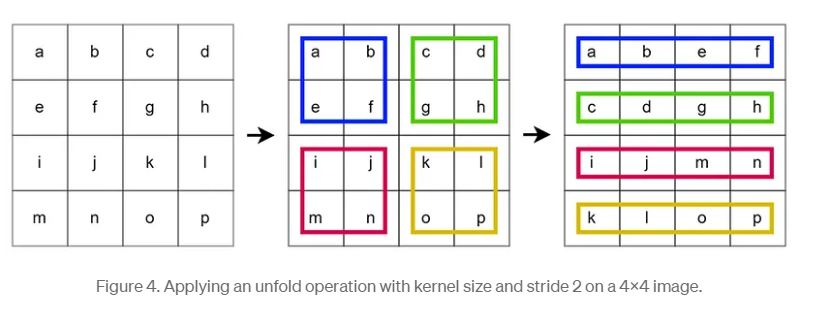

Next, the linear projection operation is done with a standard nn.Linear() layer (#(2)). In order to make the input match with the flattened patch, we need to use IN_CHANNELS*PATCH_SIZE*PATCH_SIZE for the in_features parameter, i.e., 16×16×3 = 768. The projection result dimension is then determined using the out_features param which I set to EMBED_DIM (768). It is important to note that the projection result and the flattened patch have the exact same dimension, as specified by the ViT-B architecture. If you want to implement ViT-L or ViT-H instead, you should change the projection result dimension to 1024 or 1280, respectively, which the size might no longer be the same as the flattened patches.

As the nn.Unfold() and nn.Linear() layer have been initialized, now that we have to connect these layers using the forward() function below. One thing that we need to pay attention to is that the first and second axis of the unfolded tensor need to be swapped using permute() method (#(1)). This is essentially done because we want to treat the flattened patches as a sequence of tokens, similar to how tokens are processed in NLP models. I also print out the shape of every single process done in the codeblock to help you keep track of the array dimension.

In [9]:
# Codeblock 6
patcher_unfold = PatcherUnfold()
x = torch.randn(1, 3, 224, 224)
x = patcher_unfold(x)

original	: torch.Size([1, 3, 224, 224])
after unfold	: torch.Size([1, 768, 196])
after permute	: torch.Size([1, 196, 768])
after lin proj	: torch.Size([1, 196, 768])


You can see the output above that our original image has successfully been converted to shape 1×196×768, in which 1 represents the number of images within a single batch, 196 denotes the sequence length (number of patches), and 768 is the embedding dimension.

That was the implementation of patch flattening and linear projection with the PatcherUnfold() class. We can actually achieve the same thing using PatcherConv() which the code is shown below.

In [10]:
class PatcherConv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=IN_CHANNELS,
                              out_channels=EMBED_DIM,
                              kernel_size=PATCH_SIZE,
                              stride=PATCH_SIZE)

        self.flatten = nn.Flatten(start_dim=2)

    def forward(self, x):
        print(f'original\t\t: {x.size()}')

        x = self.conv(x)    #(1)
        print(f'after conv\t\t: {x.size()}')

        x = self.flatten(x)    #(2)
        print(f'after flatten\t\t: {x.size()}')

        x = x.permute(0, 2, 1)    #(3)
        print(f'after permute\t\t: {x.size()}')

        return x

This approach might not seem as straightforward as the previous one because it does not actually flatten the patches. Rather, it uses a convolution layer with EMBED_DIM (768) number of kernels which results in a 14×14 image with 768 channels (#(1)). To obtain the same output dimension as the PatcherUnfold(), we then flatten the spatial dimension (#(2)) and swap the first and second axes of the resulting tensor (#(3)). Look at the output of Codeblock 8 below to see the detailed tensor shape after each step.

In [11]:
patcher_conv = PatcherConv()
x = torch.randn(1, 3, 224, 224)
x = patcher_conv(x)

original		: torch.Size([1, 3, 224, 224])
after conv		: torch.Size([1, 768, 14, 14])
after flatten		: torch.Size([1, 768, 196])
after permute		: torch.Size([1, 196, 768])


Additionally, it is worth noting that using nn.Conv2d() in PatcherConv() is more efficient compared to separate unfolding and linear projection in PatcherUnfold() as it combines the two steps into a single operation.

### Class Token & Positional Embedding Implementation
After all patches have been projected into an embedding dimension and arranged into a sequence, the next step is to put the class token before the first patch token in the sequence. This process is wrapped together with the positional embedding implementation inside the PosEmbedding() class as shown below.

The class token itself is initialized using nn.Parameter(), which is essentially a weight tensor (#(1)). The size of this tensor needs to match with the embedding dimension as well as the batch size, such that it can be concatenated with the existing token sequence. This tensor initially contains random values, which will be updated during the training process. In order to allow it to be updated, we need to set the requires_grad parameter to True. Similarly, we also need to employ nn.Parameter() to create the positional embedding (#(2)), yet with a different shape. In this case we set the sequence dimension to be one token longer than the original sequence to accommodate the class token we just created. Not only that, here I also initialize a dropout layer with the rate that we specified earlier (#(3)).

Afterwards, I am going to connect these layers with the forward() function in Codeblock 10 below. The tensor accepted by this function will be concatenated with the class_token using torch.cat() as written at the line marked by #(1). Next, we will perform element-wise addition between the resulting output and the positional embedding tensor (#(2)) before passing it through the dropout layer (#(3)).

In [12]:
class PosEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.class_token = nn.Parameter(torch.randn(size=(BATCH_SIZE, 1, EMBED_DIM)),
                                        requires_grad=True)    #(1)
        self.pos_embedding = nn.Parameter(torch.randn(size=(BATCH_SIZE, NUM_PATCHES+1, EMBED_DIM)),
                                          requires_grad=True)    #(2)
        self.dropout = nn.Dropout(p=DROPOUT_RATE)  #(3)

    def forward(self, x):

        class_token = self.class_token
        print(f'class_token dim\t\t: {class_token.size()}')

        print(f'before concat\t\t: {x.size()}')
        x = torch.cat([class_token, x], dim=1)    #(1)
        print(f'after concat\t\t: {x.size()}')

        x = self.pos_embedding + x    #(2)
        print(f'after pos_embedding\t: {x.size()}')

        x = self.dropout(x)    #(3)
        print(f'after dropout\t\t: {x.size()}')

        return x

As usual, let’s try to forward-propagate a tensor through this network to see if it works as expected. Keep in mind that the input of pos_embedding model is essentially the tensor produced by either PatcherUnfold() or PatcherConv().

In [13]:
pos_embedding = PosEmbedding()
x = pos_embedding(x)

class_token dim		: torch.Size([1, 1, 768])
before concat		: torch.Size([1, 196, 768])
after concat		: torch.Size([1, 197, 768])
after pos_embedding	: torch.Size([1, 197, 768])
after dropout		: torch.Size([1, 197, 768])


If we take a closer look at the tensor dimension of each step, we can observe that the size of tensor x is initially 1×196×768. After the class token has been prepended to it, the dimension becomes 1×197×768.

### Transformer Encoder Implementation
If we go back to Figure 2, it can be seen that the Transformer Encoder block comprises of four components. We are going to define all these components inside the TransformerEncoder() class shown below.

In [15]:
class TransformerEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.norm_0 = nn.LayerNorm(EMBED_DIM)    #(1)

        self.multihead_attention = nn.MultiheadAttention(EMBED_DIM,    #(2)
                                                         num_heads=NUM_HEADS,
                                                         batch_first=True,
                                                         dropout=DROPOUT_RATE)

        self.norm_1 = nn.LayerNorm(EMBED_DIM)    #(3)

        self.mlp = nn.Sequential(    #(4)
            nn.Linear(in_features=EMBED_DIM, out_features=MLP_SIZE),    #(5)
            nn.GELU(),
            nn.Dropout(p=DROPOUT_RATE),
            nn.Linear(in_features=MLP_SIZE, out_features=EMBED_DIM),    #(6)
            nn.Dropout(p=DROPOUT_RATE)
        )

    def forward(self, x):

        residual = x    #(1)
        print(f'residual dim\t\t: {residual.size()}')

        x = self.norm_0(x)    #(2)
        print(f'after norm\t\t: {x.size()}')

        x = self.multihead_attention(x, x, x)[0]    #(3)
        print(f'after attention\t\t: {x.size()}')

        x = x + residual    #(4)
        print(f'after addition\t\t: {x.size()}')

        residual = x    #(5)
        print(f'residual dim\t\t: {residual.size()}')

        x = self.norm_1(x)    #(6)
        print(f'after norm\t\t: {x.size()}')

        x = self.mlp(x)    #(7)
        print(f'after mlp\t\t: {x.size()}')

        x = x + residual    #(8)
        print(f'after addition\t\t: {x.size()}')

        return x

The two normalization steps at the line marked with #(1) and #(3) are implemented using nn.LayerNorm(). Keep in mind that layer normalization we use here is different from batch normalization we commonly see in CNNs. Batch normalization works by normalizing the values within a single feature in all samples in a batch. Meanwhile in layer normalization, all features within a single sample will be normalized. Look at the Figure 5 below to better illustrate this concept. In this example, we assume that every row represents a single sample, whereas every column is a single feature. Cells of the same color indicate that their values are normalized together.

![Batch_Layer_Norms.JPG](images/Batch_Layer_Norms.JPG)

Subsequently, we initialize an nn.MultiheadAttention() layer with EMBED_DIM (768) as the input size at the line marked by #(2) in Codeblock 12. The batch_first parameter is set to True to indicate that the batch dimension is placed at the 0-th axis of the input tensor. Generally speaking, multi-head attention itself allows the model to capture various types of relationships between image patches simultaneously. Every single head in multi-head attention focuses on different aspects of these relationships. Later on, this layer accepts three inputs: query, key, and value, which are all required to compute the so-called attention weights. By doing so, this layer can understand how much each patch should attend to every other patch. In other words, this mechanism allows the layer to capture the relationships between two or more patches. The attention mechanism employed in ViT can be perceived as the core of the entire model because this component is essentially the one that allows ViT to surpass the performance of CNNs when it comes to image recognition tasks.

The MLP component inside the Transformer Encoder is constructed using nn.Sequential() (#(4)). Here we implement two consecutive linear layers, each followed by a dropout layer. We also need to put GELU activation function right after the first linear layer. No activation function is used for the second linear layer since its purpose is just to project the tensor back to the original embedding dimension.


In the above forward() function, we first store the input tensor x into residual variable (#(1)), in which it is used to create the residual connection. Next, we normalize the input tensor (#(2)) prior to feeding it into the multi-head attention layer (#(3)). As I’ve mentioned earlier, this layer takes query, key and value as the input. In this case, tensor x is going to be used as the argument for the three parameters. Notice that I also write [0] at the same line of the code. This is essentially because an nn.MultiheadAttention() object returns two values: attention output and attention weights, where in this case we only need the former. Next, at the line marked with #(4) we perform element-wise addition between the output of the multi-head attention layer and the original input tensor. We then directly update the residual variable with the current tensor x (#(5)) after the first residual operation is performed. The second normalization operation is done at line #(6) before feeding the tensor into the MLP block (#(7)) and performing another element-wise addition operation (#(8)).

We can check whether our Transformer Encoder block implementation is correct using the Codeblock 14 below. Keep in mind that the input of the transformer_encoder model has to be the output produced by PosEmbedding().

In [16]:
transformer_encoder = TransformerEncoder()
x = transformer_encoder(x)

residual dim		: torch.Size([1, 197, 768])
after norm		: torch.Size([1, 197, 768])
after attention		: torch.Size([1, 197, 768])
after addition		: torch.Size([1, 197, 768])
residual dim		: torch.Size([1, 197, 768])
after norm		: torch.Size([1, 197, 768])
after mlp		: torch.Size([1, 197, 768])
after addition		: torch.Size([1, 197, 768])


You can see in the above output that there is no change in the tensor dimension after each step. However, if you take a closer look at how the MLP block was constructed in Codeblock 12, you will observe that its hidden layer was expanded to MLP_SIZE (3072) at the line marked by #(5). We then directly project it back to its original dimension, i.e., EMBED_DIM (768) at line #(6).

### MLP Head Implementation
The last class we are going to implement is MLPHead(). Just like the MLP layer inside the Transformer Encoder block, MLPHead() also comprises of fully-connected layers, GELU activation function and layer normalization. The entire implementation of this class can be seen in Codeblock 15 below.

In [17]:
class MLPHead(nn.Module):
    def __init__(self):
        super().__init__()

        self.norm = nn.LayerNorm(EMBED_DIM)
        self.linear_0 = nn.Linear(in_features=EMBED_DIM,
                                  out_features=EMBED_DIM)
        self.gelu = nn.GELU()
        self.linear_1 = nn.Linear(in_features=EMBED_DIM,
                                  out_features=NUM_CLASSES)    #(1)

    def forward(self, x):
        print(f'original\t\t: {x.size()}')

        x = self.norm(x)
        print(f'after norm\t\t: {x.size()}')

        x = self.linear_0(x)
        print(f'after layer_0 mlp\t: {x.size()}')

        x = self.gelu(x)
        print(f'after gelu\t\t: {x.size()}')

        x = self.linear_1(x)
        print(f'after layer_1 mlp\t: {x.size()}')

        return x

One thing to note is that the second fully-connected layer is essentially the output of the entire ViT architecture (#(1)). Hence, we need to ensure that the number of neurons matches with the number of classes available in the dataset we are going to train the model on. In this case, I assume that we have EMBED_DIM (10) number of classes. Furthermore, it is worth noting that I don’t use a softmax layer at the end since it is already implemented in nn.CrossEntropyLoss() if you want to actually train this model.

In order to test the MLPHead() model, we first need to slice the tensor produced by the Transformer Encoder block as shown at line #(1) in Codeblock 16. This is essentially done because we want to take the 0-th element in the token sequence in which it corresponds to the class token we prepended earlier at the front of the patch token sequence.

In [18]:
x = x[:, 0]    #(1)
mlp_head = MLPHead()
x = mlp_head(x)

original		: torch.Size([1, 768])
after norm		: torch.Size([1, 768])
after layer_0 mlp	: torch.Size([1, 768])
after gelu		: torch.Size([1, 768])
after layer_1 mlp	: torch.Size([1, 10])


As the test code in Codeblock 16 is run, now we can see that the final tensor shape is 1×10, which is exactly what we expect.

### The Entire ViT Architecture
At this point all ViT components have successfully been created. Hence, we can now use them to construct the entire Vision Transformer architecture. Look at the Codeblock 17 below to see how I do it.

In [19]:
class ViT(nn.Module):
    def __init__(self):
        super().__init__()

        #self.patcher = PatcherUnfold()
        self.patcher = PatcherConv()    #(1)
        self.pos_embedding = PosEmbedding()
        self.transformer_encoders = nn.Sequential(
            *[TransformerEncoder() for _ in range(NUM_ENCODERS)]    #(2)
            )
        self.mlp_head = MLPHead()

    def forward(self, x):

        x = self.patcher(x)
        x = self.pos_embedding(x)
        x = self.transformer_encoders(x)
        x = x[:, 0]    #(3)
        x = self.mlp_head(x)

        return x

There are several things I want to emphasize regarding the above code. First, at line #(1) we can use either PatcherUnfold() or PatcherConv() as they both have the same role, i.e., to do the patch flattening and linear projection step. In this case, I use the latter for no specific reason. Secondly, the Transformer Encoder block will be repeated NUM_ENCODER (12) times (#(2)) since we are going to implement ViT-Base as stated in Figure 3. Lastly, don’t forget to slice the tensor outputted by the Transformer Encoder since our MLP head will only process the class token part of the output (#(3)).

We can test whether our ViT model works properly using the following code.



In [20]:
vit = ViT().to(device)
x = torch.randn(1, 3, 224, 224).to(device)
print(vit(x).size())

original		: torch.Size([1, 3, 224, 224])
after conv		: torch.Size([1, 768, 14, 14])
after flatten		: torch.Size([1, 768, 196])
after permute		: torch.Size([1, 196, 768])
class_token dim		: torch.Size([1, 1, 768])
before concat		: torch.Size([1, 196, 768])
after concat		: torch.Size([1, 197, 768])
after pos_embedding	: torch.Size([1, 197, 768])
after dropout		: torch.Size([1, 197, 768])
residual dim		: torch.Size([1, 197, 768])
after norm		: torch.Size([1, 197, 768])
after attention		: torch.Size([1, 197, 768])
after addition		: torch.Size([1, 197, 768])
residual dim		: torch.Size([1, 197, 768])
after norm		: torch.Size([1, 197, 768])
after mlp		: torch.Size([1, 197, 768])
after addition		: torch.Size([1, 197, 768])
residual dim		: torch.Size([1, 197, 768])
after norm		: torch.Size([1, 197, 768])
after attention		: torch.Size([1, 197, 768])
after addition		: torch.Size([1, 197, 768])
residual dim		: torch.Size([1, 197, 768])
after norm		: torch.Size([1, 197, 768])
after mlp		: torch.Siz

You can see here that the input which the dimension is 1×3×224×224 has been converted to 1×10, which indicates that our model works as expected.

Note: you need to comment out all the prints to make the output looks more concise like this.

Additionally, we can also see the detailed structure of the network using the summary() function we imported at the beginning of the code. You can observe that the total number of parameters is around 86 million, which matches the number stated in Figure 3.

In [21]:
summary(vit, input_size=(1,3,224,224))

original		: torch.Size([1, 3, 224, 224])
after conv		: torch.Size([1, 768, 14, 14])
after flatten		: torch.Size([1, 768, 196])
after permute		: torch.Size([1, 196, 768])
class_token dim		: torch.Size([1, 1, 768])
before concat		: torch.Size([1, 196, 768])
after concat		: torch.Size([1, 197, 768])
after pos_embedding	: torch.Size([1, 197, 768])
after dropout		: torch.Size([1, 197, 768])
residual dim		: torch.Size([1, 197, 768])
after norm		: torch.Size([1, 197, 768])
after attention		: torch.Size([1, 197, 768])
after addition		: torch.Size([1, 197, 768])
residual dim		: torch.Size([1, 197, 768])
after norm		: torch.Size([1, 197, 768])
after mlp		: torch.Size([1, 197, 768])
after addition		: torch.Size([1, 197, 768])
residual dim		: torch.Size([1, 197, 768])
after norm		: torch.Size([1, 197, 768])
after attention		: torch.Size([1, 197, 768])
after addition		: torch.Size([1, 197, 768])
residual dim		: torch.Size([1, 197, 768])
after norm		: torch.Size([1, 197, 768])
after mlp		: torch.Siz

Layer (type:depth-idx)                   Output Shape              Param #
ViT                                      [1, 10]                   --
├─PatcherConv: 1-1                       [1, 196, 768]             --
│    └─Conv2d: 2-1                       [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                      [1, 768, 196]             --
├─PosEmbedding: 1-2                      [1, 197, 768]             152,064
│    └─Dropout: 2-3                      [1, 197, 768]             --
├─Sequential: 1-3                        [1, 197, 768]             --
│    └─TransformerEncoder: 2-4           [1, 197, 768]             --
│    │    └─LayerNorm: 3-1               [1, 197, 768]             1,536
│    │    └─MultiheadAttention: 3-2      [1, 197, 768]             2,362,368
│    │    └─LayerNorm: 3-3               [1, 197, 768]             1,536
│    │    └─Sequential: 3-4              [1, 197, 768]             4,722,432
│    └─TransformerEncoder: 2-5           [1, 197, 768] 

: 